In [1]:
import pandas as pd
import networkx as nx
import igraph as ig
import random as rand
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
'''
Two dataframes are directly created from the original files.
'''

epinions_df = pd.read_csv("Data/soc-sign-epinions.txt",sep = '\t', comment = '#', 
                          names = ['FromNodeId', 'ToNodeId', 'Sign'], index_col = False)

slashdot_df = pd.read_csv("Data/soc-sign-Slashdot090221.txt",sep = '\t', comment = '#', 
                          names = ['FromNodeId', 'ToNodeId', 'Sign'], index_col = False)

In [3]:
slashdot_df

,FromNodeId,ToNodeId,Sign
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1
...,...,...,...
549197,82140,81612,1
549198,82141,82129,1
549199,82141,82142,1
549200,82143,81974,1


In [4]:
'''
Cell with code used to parse the wiki data.
'''

filename = "Data/wikiElec.ElecBs3.txt"

with open(filename, errors = 'ignore') as f:
    lines = f.readlines()
    
'''
After opening the file, a list made of the lines of the file is generated, and subsequently treated to have only the lines
featuring the voted person and the people that vote.
'''
    
lines = [x.strip() for x in lines]

splines = [i.split('\t') for i in lines]

parslines = [x for x in splines if (x[0] == 'U' or x[0] == 'V' or x[0] == 'E')]

'''
Then a for loop passes through the whole list, extracting and putting the data of interest in several lists.
'''

fromlist = []
tolist = []
signlist = []
voted_user_id = ''

for line in parslines:
    
    if line[0] == 'U':
        voted_user_id = line[1]
    if ((line[0] == 'V') and (line[1] != '0')):
        fromlist.append(line[2])
        tolist.append(voted_user_id)
        signlist.append(line[1])
        
'''
The dataframe is generated using the aforementioned lists, converted them from string to numeric ones.
'''

wikipedia_df = pd.DataFrame(columns = ['FromNodeId', 'ToNodeId', 'Sign'])

wikipedia_df.FromNodeId = list(map(int,fromlist))
wikipedia_df.ToNodeId = list(map(int,tolist))
wikipedia_df.Sign = list(map(int,signlist))

In [5]:
'''
Cell to do the needed modifications on wikipedia_df.
'''

wikiinv_df = wikipedia_df.reindex(index=wikipedia_df.index[::-1])
wikiinv_df = wikiinv_df.drop_duplicates(subset=['FromNodeId', 'ToNodeId']) 

In [6]:
'''
This cell converts every dataframe in two graph structures, a networkx and an igraph one, using the function below to
lighten up the code.
'''

def convert_to_graph(df):
    # Input:
    # -- df: a pandas dataframe
    # Output:
    # -- gnx: a networkx graph structure;
    # -- g: a igraph graph structure
    
    gnx = nx.from_pandas_edgelist(df, source = 'FromNodeId', target = 'ToNodeId', edge_attr = 'Sign', 
                                  create_using = nx.DiGraph)
    
    g = ig.Graph.TupleList(gnx.edges(), directed = True)
    
    return gnx, g

wikipedia_gnx, wikipedia_g = convert_to_graph(wikiinv_df)

In [7]:
'''
Function to calculate the trust score
'''

def trust_dispenser(G):
    
    trust = []
    
    
    m = {v: i for i, v in enumerate(G)}
    
    for v in G:
        count = 0;
        vnbrs = set(G.pred[v])
        for u in vnbrs:
            
            count += G[u][v]['Sign']
            
        
        trust.append([v, count])

    return trust

In [24]:
def transpose_trust(G,df):
    
    propagation = []
    
    m = {v: i for i, v in enumerate(G)}
    
    for v in G:
        
        vnbrs = set(G.pred[v]) | set(G.succ[v])
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            neighbors = (vnbrs | set(G.succ[u]) | set(G.pred[u])) - {u, v}
            
            for w in neighbors:
                
                if (m[v] < m[w] < m[u]):
                    
                    if (G.has_edge(v, w) and G.has_edge(u, w)):
                        
                        if not(G.has_edge(v, u)):
                            
                            
                            if (((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == 1)) or ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == -1))):
                            
                                V = df.Trust[df.Node == v].to_numpy()
                                U = df.Trust[df.Node == u].to_numpy()
                            
                                if V>U:
                                
                                    propagation.append([v, u, -0.5])
                                else:
                                
                                    propagation.append([v, u, 0.5])
                            if ((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == -1)):
                            
                                propagation.append([v, u, 0.5])
                            if ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == 1)):
                            
                                propagation.append([v, u, -0.5])
                                
                        if not(G.has_edge(u, v)):
                            
                                
                            if (((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == 1)) or ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == -1))):
                            
                                V = df.Trust[df.Node == v].to_numpy()
                                U = df.Trust[df.Node == u].to_numpy()
                            
                                if V>U:
                                
                                    propagation.append([u, v, 0.5])
                                else:
                                
                                    propagation.append([u, v, -0.5])
                            if ((G[v][w]['Sign'] == 1) and (G[u][w]['Sign'] == -1)):
                            
                                propagation.append([u, v, -0.5])
                            if ((G[v][w]['Sign'] == -1) and (G[u][w]['Sign'] == 1)):
                            
                                propagation.append([u, v, 0.5])
                                
                                

    return propagation

In [9]:
def direct_propagation(G, df):
    
    propagation = []
    
    m = {v: i for i, v in enumerate(G)}
    
    for v in G:
        
        vnbrs = set(G.pred[v]) | set(G.succ[v])
        for u in vnbrs:
            if m[u] <= m[v]:
                continue
            neighbors = (vnbrs | set(G.succ[u]) | set(G.pred[u])) - {u, v}
            
            for w in neighbors:
                
                if (m[v] < m[w] < m[u]):
                    
                    if (G.has_edge(v, w) and G.has_edge(w, u) and not(G.has_edge(v, u))):
                        
                        if ((G[v][w]['Sign'] == 1) and (G[w][u]['Sign'] == 1)):
                            
                            propagation.append([v, u, 0.5])
                        if ((G[v][w]['Sign'] == -1) and (G[w][u]['Sign'] == -1)):
                            
                            propagation.append([v, u, -0.5])
                        if (((G[v][w]['Sign'] == -1) and (G[w][u]['Sign'] == 1)) or ((G[v][w]['Sign'] == 1) and (G[w][u]['Sign'] == -1))):
                            
                            V = df.Trust[df.Node == v].to_numpy()
                            U = df.Trust[df.Node == u].to_numpy()
                            
                            if V>U:
                                
                                propagation.append([v, u, -0.5])
                            else:
                                
                                propagation.append([v, u, 0.5])
                                          
            

    return propagation

In [10]:
'''
Creating the trust score df
'''

trustscore = trust_dispenser(wikipedia_gnx)
trustscore_df = pd.DataFrame(trustscore, columns = ['Node', 'Trust'])
trustscore_df

,Node,Trust
0,3404,81
1,6307,-6
2,8243,0
3,6885,0
4,7053,0
...,...,...
7113,85,0
7114,84,0
7115,63,0
7116,61,20


In [11]:
'''
Create direct propagation df
'''

propagation_dir = direct_propagation(wikipedia_gnx, trustscore_df)
propagation_dir_data = pd.DataFrame(propagation_dir, columns = ['FromNodeId', 'ToNodeId', 'Sign'])
propagation_dir_gnx, propagation_dir_g = convert_to_graph(propagation_dir_data)
propagation_dir_score = trust_dispenser(propagation_dir_gnx)
propagation_dir_df = pd.DataFrame(propagation_dir_score, columns = ['Node', 'Trust'])
propagation_dir_df

,Node,Trust
0,3404,0.0
1,3084,3.0
2,1549,27.0
3,3615,4.0
4,3144,7.0
...,...,...
935,592,0.5
936,151,0.0
937,587,0.5
938,1199,-0.5


In [12]:
'''
Merge the dataframes
'''

wiki_direct_df = trustscore_df.merge(propagation_dir_df, how = 'left', left_on = 'Node', right_on = 'Node').fillna(0)
wiki_direct_df['Trust'] = (wiki_direct_df.Trust_x + wiki_direct_df.Trust_y)
wiki_direct_df['Diff'] = (wiki_direct_df.Trust - trustscore_df.Trust)
wiki_direct_df

,Node,Trust_x,Trust_y,Trust,Diff
0,3404,81,0.0,81.0,0.0
1,6307,-6,0.0,-6.0,0.0
2,8243,0,0.0,0.0,0.0
3,6885,0,0.0,0.0,0.0
4,7053,0,0.0,0.0,0.0
...,...,...,...,...,...
7113,85,0,0.0,0.0,0.0
7114,84,0,0.0,0.0,0.0
7115,63,0,0.0,0.0,0.0
7116,61,20,0.0,20.0,0.0


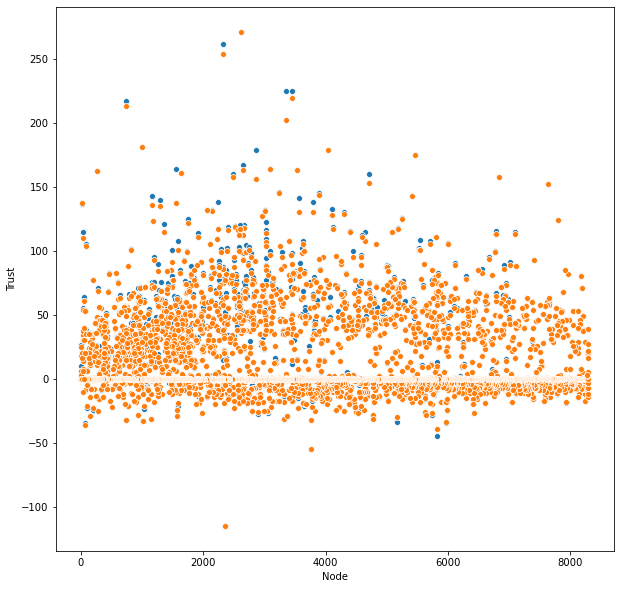

In [13]:
plt.figure(figsize = (10,10))

sns.scatterplot(x= 'Node', y="Trust", data=wiki_direct_df)
sns.scatterplot(x= 'Node', y="Trust", data=trustscore_df)

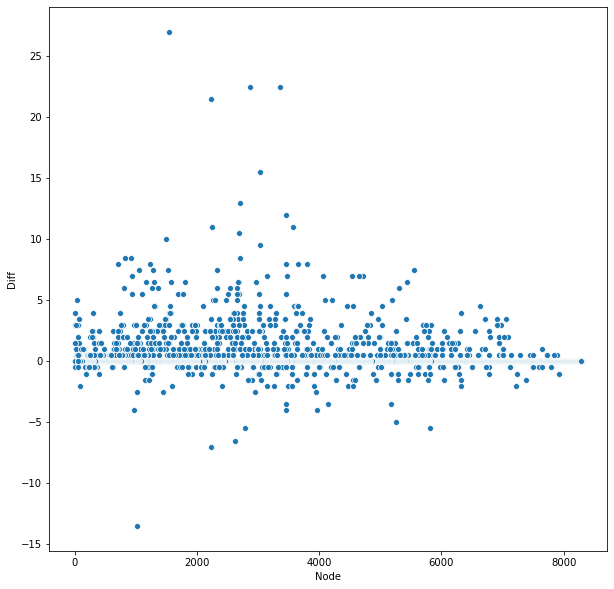

In [14]:
plt.figure(figsize = (10,10))

sns.scatterplot(x= 'Node', y="Diff", data=wiki_direct_df)

In [25]:
'''
Create transpose propagation df
'''
propagation_tra = transpose_trust(wikipedia_gnx, trustscore_df)
propagation_tra_data = pd.DataFrame(propagation_tra, columns = ['FromNodeId', 'ToNodeId', 'Sign'])
propagation_tra_gnx, propagation_tra_g = convert_to_graph(propagation_tra_data)
propagation_tra_score = trust_dispenser(propagation_tra_gnx)
propagation_tra_df = pd.DataFrame(propagation_tra_score, columns = ['Node', 'Trust'])
propagation_tra_df

,Node,Trust
0,3586,18.5
1,3404,0.0
2,2565,50.5
3,11,-169.5
4,3084,1.5
...,...,...
2685,45,-1.0
2686,40,0.5
2687,342,-0.5
2688,677,0.0


In [ ]:
'''
Merge the dataframes
'''

wiki_tra_df = trustscore_df.merge(propagation_tra_df, how = 'left', left_on = 'Node', right_on = 'Node').fillna(0)
wiki_tra_df['Trust'] = (wiki_tra_df.Trust_x + wiki_tra_df.Trust_y)
wiki_tra_df['Diff'] = (wiki_tra_df.Trust - trustscore_df.Trust)
wiki_tra_df

In [ ]:
plt.figure(figsize = (10,10))

sns.scatterplot(x= 'Node', y="Trust", data=wiki_tra_df)
sns.scatterplot(x= 'Node', y="Trust", data=trustscore_df)

In [ ]:
plt.figure(figsize = (10,10))

sns.scatterplot(x= 'Node', y="Diff", data=wiki_tra_df)

# From now on the quality drops! (not corrected, just tests)

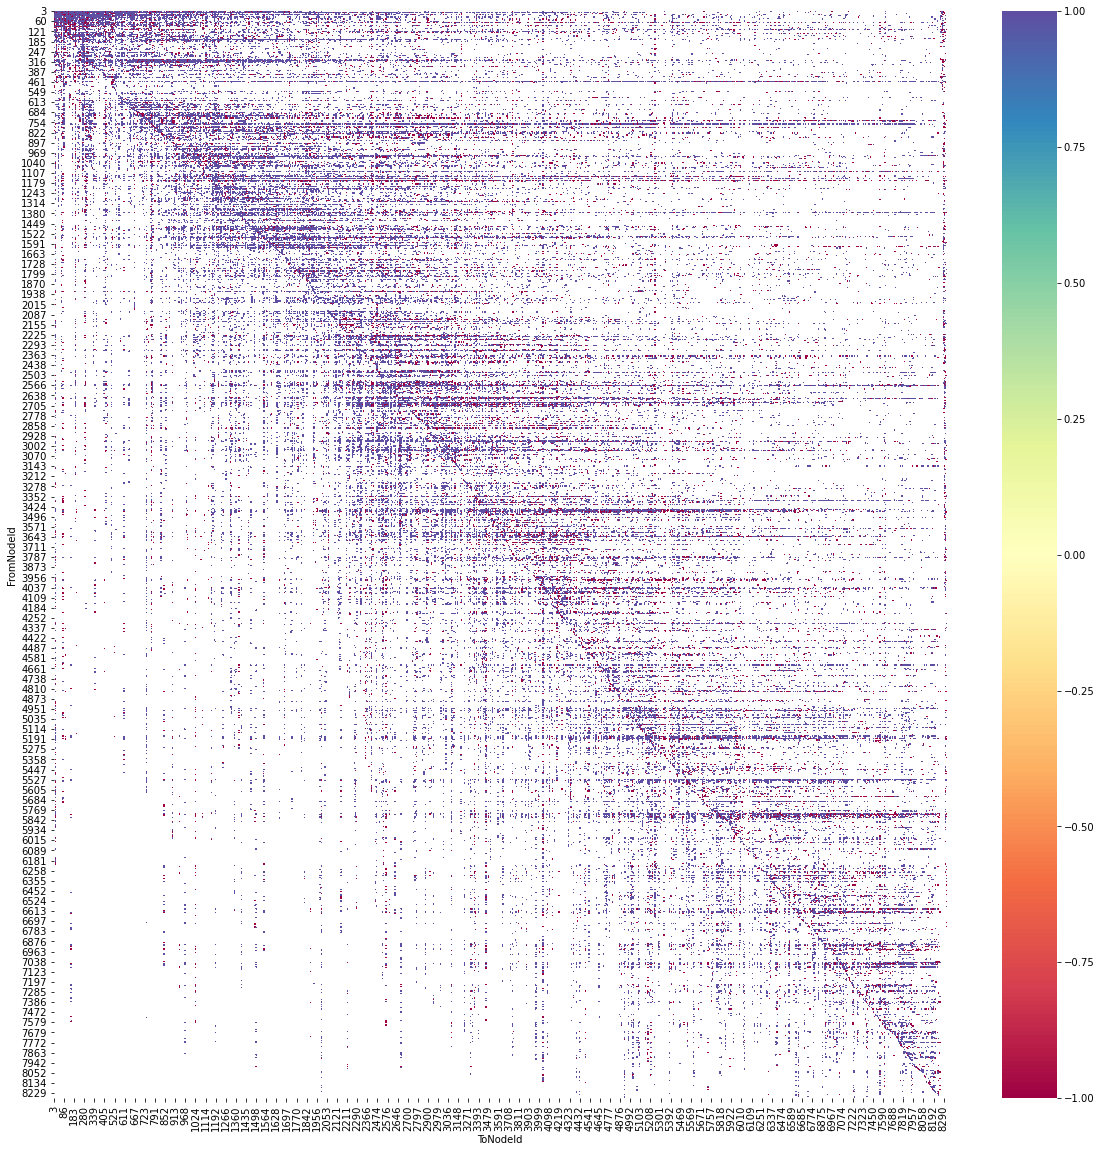

In [41]:
plt.figure(figsize = (10,10))

wiki_visu = wikiinv_df.pivot('FromNodeId', 'ToNodeId', 'Sign')
ax = sns.heatmap(wiki_visu, cmap = "Spectral")

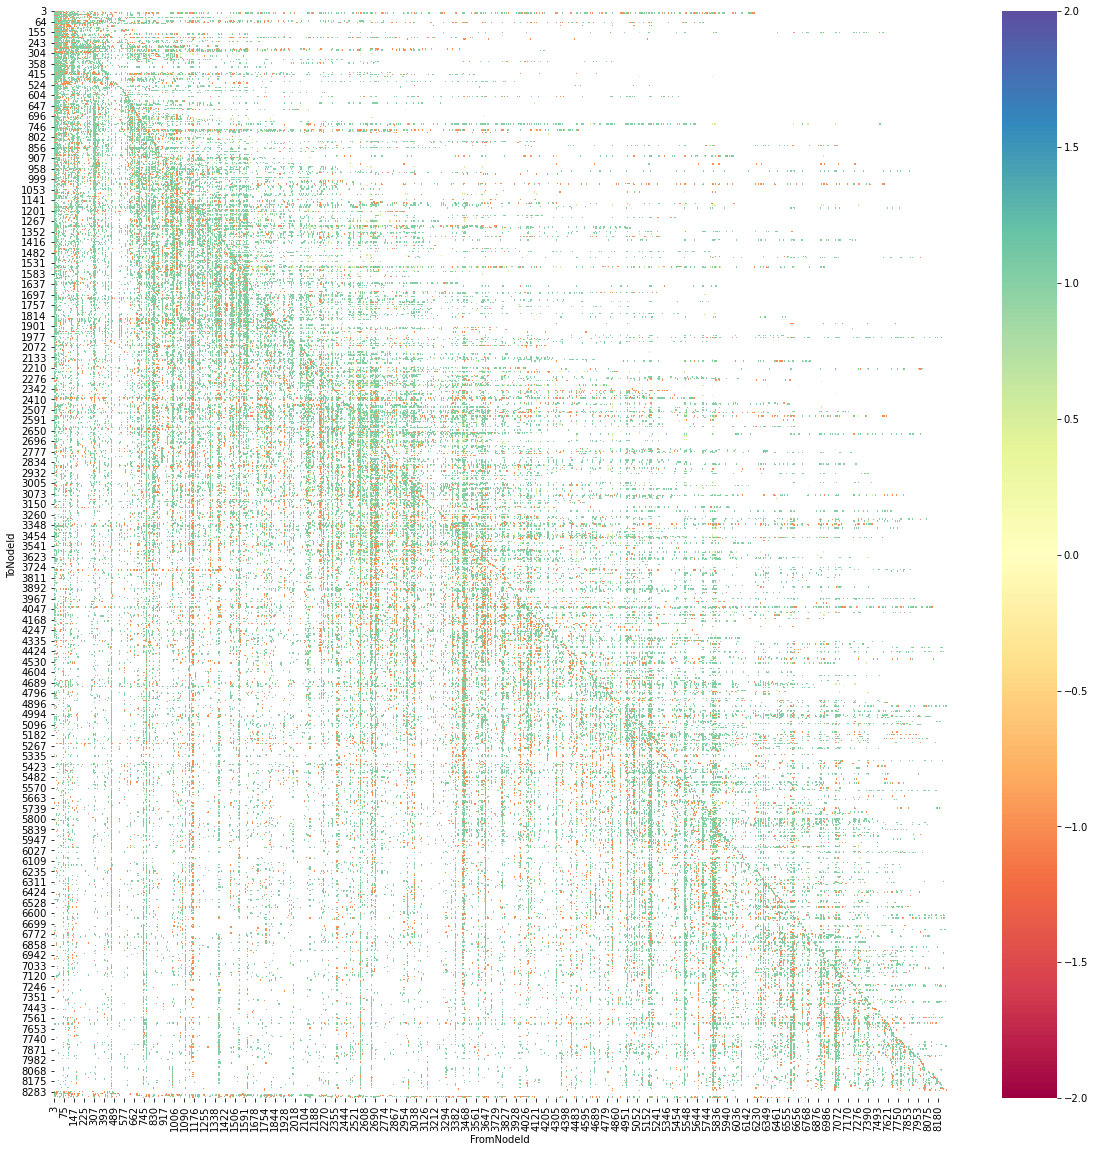

In [55]:
plt.figure(figsize = (20,20))


direct_prop_visu = DP_wiki_df.pivot('ToNodeId','FromNodeId',  'Sign')

ax = sns.heatmap(direct_prop_visu, cmap = "Spectral", vmax = 2, vmin = -2)
